# Import Packages and Models

In [1]:
experiment=None

In [1]:
# experiment (optional)
from comet_ml import Experiment
experiment = Experiment(api_key="YkPEmantOag1R1VOJmXz11hmt", parse_args=False, project_name='ocr_pipeline')
experiment.set_name('pipeline_cv_east_handwriten_twolines_crop_merged')

COMET INFO: old comet version (1.0.44) detected. current: 1.0.56 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Failing to collect the installed os packages
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/yikeqicn/ocr-pipeline/ec505155b9584d6fbe49f135a73215ca



In [2]:
import numpy as np
import argparse
import time
import cv2
import os
import tensorflow as tf
from glob import glob
from os.path import join, basename, dirname
from east.model import *
from recognition.Model import Model, DecoderType
from recognition.utils import log_image
from wordsegmentation.WordSegmentation import *

# Define Public Arguments

In [3]:
parser = argparse.ArgumentParser()
#general:
parser.add_argument("-debug_folder", "--debug_folder", type=str,default='/root/WordSegmentationRecognitionPipeline/src/debug/',help="path to debug folder")

# EAST model:
## parameter
parser.add_argument("-east_w", "--east_width", type=int, default=1920,help=" east model resized image width (should be multiple of 32)")
parser.add_argument("-east_e", "--east_height", type=int, default=1920,help="east model resized image height (should be multiple of 32)")
parser.add_argument("-mini_conf", "--mini_conf", type=int, default=0.5,help="mini_confidence for crop")

## ckpt
parser.add_argument("-east", "--east", type=str,default='/root/WordSegmentationRecognitionPipeline/src/east/frozen_east_text_detection.pb',help="path to input EAST text detector")
## input image root
parser.add_argument("-image_root", "--image_root", type=str,default='/root/WordSegmentationRecognitionPipeline/src/Inputs/',help="path to input image root")

# Recognition model:



_StoreAction(option_strings=['-image_root', '--image_root'], dest='image_root', nargs=None, const=None, default='/root/WordSegmentationRecognitionPipeline/src/Inputs/', type=<class 'str'>, choices=None, help='path to input image root', metavar=None)

In [4]:
# Recognition Model
# basic operations
parser.add_argument("-name", default='dense_128_32_noartifact_beamsearch_5_datasets', type=str, help="name of the log")
parser.add_argument("-gpu", default='-1', type=str, help="gpu numbers")
#parser.add_argument("-train", help="train the NN", action="store_true")
#parser.add_argument("-validate", help="validate the NN", action="store_true")
parser.add_argument("-transfer", action="store_true")
#actually not effective:
parser.add_argument("-batchesTrained", default=0, type=int, help='number of batches already trained (for lr schedule)') 
# beam search
parser.add_argument("-beamsearch", help="use beam search instead of best path decoding",default=True, action="store_true")
parser.add_argument("-wordbeamsearch", help="use word beam search instead of best path decoding", action="store_true")
# training hyperparam
parser.add_argument("-batchsize", default=50, type=int, help='batch size') # actually not effective in infrerence
parser.add_argument("-lrInit", default=1e-2, type=float, help='initial learning rate') # actually not effective
parser.add_argument("-optimizer", default='rmsprop', help="adam, rmsprop, momentum") # actually not effective
parser.add_argument("-wdec", default=1e-4, type=float, help='weight decay') # acctually not effective
#parser.add_argument("-lrDrop1", default=10, type=int, help='step to drop lr by 10 first time')
#parser.add_argument("-lrDrop2", default=1000, type=int, help='step to drop lr by 10 sexond time')
#parser.add_argument("-epochEnd", default=40, type=int, help='end after this many epochs')
# trainset hyperparam
#parser.add_argument("-noncustom", help="noncustom (original) augmentation technique", action="store_true")
#parser.add_argument("-noartifact", help="dont insert artifcats", action="store_true")
#parser.add_argument("-iam", help='use iam dataset', action='store_true')
# densenet hyperparam
parser.add_argument("-nondensenet", help="use noncustom (original) vanilla cnn", action="store_true")
parser.add_argument("-growth_rate", default=12, type=int, help='growth rate (k)')
parser.add_argument("-layers_per_block", default=18, type=int, help='number of layers per block')
parser.add_argument("-total_blocks", default=5, type=int, help='nuber of densenet blocks')
parser.add_argument("-keep_prob", default=1, type=float, help='keep probability in dropout')
parser.add_argument("-reduction", default=0.4, type=float, help='reduction factor in 1x1 conv in transition layers')
parser.add_argument("-bc_mode", default=True, type=bool, help="bottleneck and compresssion mode")
# rnn,  hyperparams
parser.add_argument("-rnndim", default=256, type=int, help='rnn dimenstionality') #256
parser.add_argument("-rnnsteps", default=32, type=int, help='number of desired time steps (image slices) to feed rnn')
# img size
parser.add_argument("-imgsize", default=[128,32], type=int, nargs='+') #qyk default 128,32
# testset crop
#parser.add_argument("-crop_r1", default=3, type=int)
#parser.add_argument("-crop_r2", default=28, type=int)
#parser.add_argument("-crop_c1", default=10, type=int)
#parser.add_argument("-crop_c2", default=115, type=int)
# filepaths
#parser.add_argument("-dataroot", default='/root/datasets', type=str)
parser.add_argument("-ckptroot", default='/root/ckpt', type=str)
#parser.add_argument("-urlTransferFrom", default=None, type=str)

args = parser.parse_known_args()[0]
home = os.environ['HOME']
name = args.name
ckptroot = join(home, 'ckpt')
args.ckptpath = join(ckptroot, name)
os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu

In [5]:
args.debug_folder

'/root/WordSegmentationRecognitionPipeline/src/debug/'

# Set Image Path

In [6]:
#image_paths=glob(args.image_root+'**.jpg')
image_paths=glob(args.image_root+'twolines.jpg')

# Initiate Models

In [7]:
model_east=east_cv2(args,experiment=experiment)

[INFO] loading EAST text detector...


In [8]:
decoderType = DecoderType.BestPath
if args.beamsearch:
    decoderType = DecoderType.BeamSearch
elif args.wordbeamsearch:
    decoderType = DecoderType.WordBeamSearch

model_recg = Model(args, open(join(args.ckptpath, 'charList.txt')).read(), decoderType, mustRestore=True)

Build Densenet4htr model with 5 blocks, 9 bottleneck layers and 9 composite layers each.
Depth: 96
Reduction at transition layers: 0.4
Instructions for updating:
Colocations handled automatically by placer.
densenet feature extractor graph built in (sec): 7.600031614303589
Total training params: 0.5M
shape of cnn output: [None, 32, 1, 178]
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


COMET ERROR: Failed to extract parameters from Estimator.init()


Python: 3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
Tensorflow: 1.12.0-rc0
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /root/ckpt/dense_128_32_noartifact_beamsearch_5_datasets/model-35
Init with stored values from /root/ckpt/dense_128_32_noartifact_beamsearch_5_datasets/model-35


# CV2 EAST Detection

In [9]:
image_paths[0]

'/root/WordSegmentationRecognitionPipeline/src/Inputs/twolines.jpg'

In [10]:
images,boundingboxes=model_east.crop(image_paths[0])

[INFO] text detection took 2.212843 seconds


In [11]:
merged_boxes=non_max_suppression_merge(boundingboxes, probs=None, overlapThresh=0.2)

In [12]:
print(len(images))
print(len(merged_boxes))

8
8


In [13]:
orig=cv2.imread(image_paths[0])
images_rlt=[]
boundingbox_rlt=[]        
# loop over the bounding boxes
for (startX, startY, endX, endY) in merged_boxes:
    # crop
    img=orig[startY:endY+1,startX:endX+1]  
    # deal with vertical alignment, strong assumption
    if endY-startY>1.2*(endX-startX):
        # draw the bounding box on the image
        
        img=img.transpose((1,0,2))
        
        if startX>0.9*orig.shape[1]:
            img=np.flip(img,axis=1)
          
    # grey and size normalize, compatible to recognition
    img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img=cv2.resize(img,(args.imgsize[0],args.imgsize[1]),interpolation=cv2.INTER_CUBIC)
    img=cv2.transpose(img)
            
    images_rlt.append(img)
    boundingbox_rlt.append((startX,startY,endX,endY)) 
    if experiment!=None:
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
        
if experiment!=None:    
    imageFile=args.debug_folder+'east_test_merged_cropped.jpg'
    cv2.imwrite(imageFile,orig)
    experiment.log_image(imageFile)
    time.sleep(.2)
    os.remove(imageFile)        

images=images_rlt

# Recognition 

Assumption: 
1. The number of words is less than 500, let's try to predict them in one batch
2. The images in images list variable are all on word level.

In [14]:
recognizeds=model_recg.inferBatch(images)

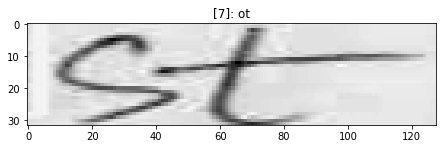

In [16]:
#log experiment
if experiment !=None:
    result_sets=zip(images,recognizeds)
    for idx, (image, label) in enumerate(result_sets):
        text = '['+str(idx)+']: '+label
        log_image(experiment, image, text, '', args.debug_folder, counter='', epoch='')
        #counter += 1 # previous batch.imgs[i]

In [15]:
recognizeds

['Angeles', 'ork', 'W', 'to', 'r0m', 'be', 'the', 'ot']